# Model Compression in Large Language Models 🧠⚡

Welcome! In this notebook, you’ll explore how **large language models (LLMs)** can be made smaller, faster, and more efficient through two powerful techniques:  
**Knowledge Distillation** and **Quantization**.

You’ll start by studying how a large, powerful “teacher” model can transfer its knowledge to a smaller “student” model, a process known as **distillation**.  
Then you’ll see how **quantization** can further compress models by reducing numerical precision, cutting down memory use, and speeding up inference without major accuracy loss.

We’ll focus on the **Masked Language Modeling (MLM)** task, the same pretraining objective used for models like **BERT** and **DistilBERT**, and evaluate how both techniques preserve performance while improving efficiency.

### 🔍 What you’ll do
- 📚 **Learn key concepts** → understand what distillation and quantization mean, and why they matter for deploying LLMs.  
- 🧩 **Load a real dataset** → use the **Yelp Polarity** dataset to work with natural, human-written text.  
- 🧠 **Create masked samples** → hide random words and challenge models to fill in the blanks.  
- ⚖️ **Compare teacher vs. student** → test how well **DistilBERT** imitates **BERT**.  
- ⚡ **Quantize the teacher** → run BERT in 8-bit precision using **BitsAndBytes** to measure speed and accuracy changes.  
- 📊 **Evaluate and visualize results** → compare predictions, agreement scores, KL divergence, and runtime performance.  

✨ By the end, you’ll see how **distillation and quantization work together** to make modern language models leaner, faster, and easier to deploy — all while keeping their intelligence intact. Let’s get started!


In [ ]:
import random
import os, gc, torch
from transformers import AutoModelForMaskedLM, AutoTokenizer, pipeline
import torch

import matplotlib.pyplot as plt

from transformers import pipeline, AutoTokenizer
from datasets import load_dataset
from tqdm import tqdm

import numpy as np
import time
import torch.nn.functional as F

from transformers import AutoModelForMaskedLM, AutoTokenizer, pipeline

## 🧾 Dataset: Yelp Polarity

For this demo, we’ll use the **Yelp Polarity** dataset, a collection of real user reviews from Yelp labeled as **positive** or **negative**.  
Even though this dataset is designed for sentiment classification, we’ll repurpose its text for **masked language modeling**.  

Using real, naturally written reviews helps us test how well the teacher (**BERT**) and student (**DistilBERT**) handle everyday language and maintain consistent predictions under distillation.

**`TODO:`** Load the train set of the `yelp_polarity`dataset. Only 1% shoudl suffice.

In [ ]:
dataset = load_dataset("yelp_polarity", split="train[:1%]")
dataset

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset({
    features: ['text', 'label'],
    num_rows: 5600
})

### 🧩 Prepare Masked Sentences

Your goal here is to prepare a small set of sentences that include a **[MASK]** token.  
You’ll use these sentences later to test how well BERT and DistilBERT predict missing words.


**`TODO:`**
1. Load the **BERT tokenizer** so you can check the token length of each sentence.  
2. Write a function that takes a sentence, randomly selects one word, replaces it with `[MASK]`, and returns both the masked sentence and the original word.  
3. Make sure to skip sentences that are too short or exceed **512 tokens** when tokenized.  
4. Loop through the dataset, apply your function, and keep only the valid masked sentences.  
5. Stop once you have collected **200 valid examples**, then store them in two lists — one for masked sentences and one for the original words.

When you’re done, print how many masked sentences you successfully created.  
These will be your **test inputs** for the next experiment.


In [ ]:
# Load tokenizer and dataset
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def mask_random_word(text):
    words = text.split()
    if len(words) < 5:
        return None
    idx = random.randint(1, len(words) - 2)
    original = words[idx]
    words[idx] = "[MASK]"
    masked_text = " ".join(words)
    # Check length
    if len(tokenizer(masked_text)["input_ids"]) > 512:
        return None
    return masked_text, original

# --- Collect 200 valid masked sentences ---
masked_samples = []
texts = [t for t in dataset["text"] if len(t.split()) > 5]

for t in texts:
    masked = mask_random_word(t)
    if masked:
        masked_samples.append(masked)
    if len(masked_samples) >= 200:
        break

# Separate into lists
masked_sentences, originals = zip(*masked_samples)

print(f"✅ Collected {len(masked_sentences)} valid masked sentences.")

Token indices sequence length is longer than the specified maximum sequence length for this model (1019 > 512). Running this sequence through the model will result in indexing errors


✅ Collected 200 valid masked sentences.


## ⚙️ Distillation and Pipelins

In Hugging Face’s Transformers library, **pipelines** provide a simple, high-level interface for running common NLP tasks without needing to manually handle tokenization, model inputs, or post-processing.

#### Masked Language Modeling (MLM)
- The `"fill-mask"` pipeline is designed for **Masked Language Modeling (MLM)** tasks.  
- It automatically detects the `[MASK]` token in a sentence and predicts which words are most likely to fill that blank.  
- Under the hood, the pipeline handles tokenization, model inference, and decoding — returning readable word predictions with their probabilities.

#### Teacher and Student Models
- `pipeline("fill-mask", model="bert-base-uncased")` loads **BERT**, our **teacher model** — large and highly accurate.  
- `pipeline("fill-mask", model="distilbert-base-uncased")` loads **DistilBERT**, our **student model** — smaller, faster, and distilled from BERT.

In this setup, both pipelines perform the same task, allowing us to directly compare their predictions and efficiency.  
For more details, check out the [Transformers pipeline documentation](https://huggingface.co/docs/transformers/en/main_classes/pipelines).

**`TODO:`** Load the teacher and student models through a `pipeline` class.

In [ ]:
teacher = pipeline("fill-mask", model="bert-base-uncased")
student = pipeline("fill-mask", model="distilbert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0
Device set to use cuda:0


### 📊 Task: Compare Teacher and Student Performance

Now that you have your masked sentences and both models loaded, it’s time to **evaluate how similar their predictions are** and how efficiently they run.

In this section, you’ll write a loop that goes through each masked sentence, asks both models to fill in the blank, and records several measurements:

1. **Inference time**  
   Measure how long each model takes to make a prediction. This helps show how much faster the student (DistilBERT) is compared to the teacher (BERT).

2. **Top-1 agreement**  
   Check if the two models predict the **same top word** for the `[MASK]` position.

3. **Top-5 overlap**  
   Compare the sets of their top-5 predictions. Count how many of the teacher’s top-5 words also appear in the student’s top-5 list.

4. **KL divergence**  
   Compute the Kullback–Leibler divergence between the teacher’s and student’s predicted probability distributions.  
   A lower KL value means the student’s predictions are closer to the teacher’s.

After looping through all samples, calculate and print the **average results** across the dataset.  
These metrics together will show how well the student model preserves the teacher’s knowledge while being faster to run.


**`TODO:`** Implement the experiment as described above.

In [ ]:

top1, top5, kl_scores = [], [], []
t_times, s_times = [], []

for i, (masked, original) in enumerate(tqdm(zip(masked_sentences, originals))):
    if "[MASK]" not in masked:
        continue

    # Teacher predictions
    t0 = time.time()
    t_preds = teacher(masked)
    t_times.append(time.time() - t0)

    # Student predictions
    s0 = time.time()
    s_preds = student(masked)
    s_times.append(time.time() - s0)

    # Normalize probabilities
    t_probs = np.array([p['score'] for p in t_preds])
    s_probs = np.array([p['score'] for p in s_preds])
    t_probs /= t_probs.sum()
    s_probs /= s_probs.sum()

    # Top-1
    top1.append(int(t_preds[0]['token_str'] == s_preds[0]['token_str']))

    # Top-5 overlap
    t5 = {p['token_str'] for p in t_preds[:5]}
    s5 = {p['token_str'] for p in s_preds[:5]}
    top5.append(len(t5 & s5) / 5)

    # KL divergence
    min_len = min(len(t_probs), len(s_probs))
    kl = F.kl_div(
        torch.log(torch.tensor(s_probs[:min_len] + 1e-10)),
        torch.tensor(t_probs[:min_len] + 1e-10),
        reduction="sum"
    ).item()

    kl_scores.append(kl)

# Aggregate metrics
print(f"\n📊 Results on 200 real WikiText samples:")
print(f"Top-1 agreement: {np.mean(top1)*100:.2f}%")
print(f"Top-5 overlap:   {np.mean(top5)*100:.2f}%")
print(f"KL divergence:   {np.mean(kl_scores):.4f}")
print(f"Speedup:         {np.mean(t_times)/np.mean(s_times):.2f}× faster")

9it [00:01,  7.31it/s]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
200it [00:17, 11.51it/s]


📊 Results on 200 real WikiText samples:
Top-1 agreement: 53.00%
Top-5 overlap:   54.20%
KL divergence:   0.2038
Speedup:         1.44× faster


**`TODO:`** Plot the Top-1 Agreement and the Top-5 Overlap between the student and the teacher.

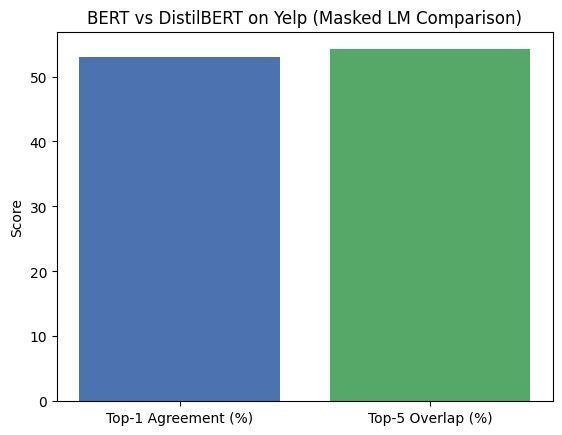

In [ ]:
metrics = {
    "Top-1 Agreement (%)": np.mean(top1)*100,
    "Top-5 Overlap (%)": np.mean(top5)*100,
}

plt.bar(metrics.keys(), metrics.values(), color=["#4c72b0", "#55a868"])
plt.ylabel("Score")
plt.title("BERT vs DistilBERT on Yelp (Masked LM Comparison)")
plt.show()


## ⚡ Task: Quantize the Teacher Model with Bitsandbytes

Now you’ll explore **quantization**

In this exercise, you will:
1. Load the original **BERT** teacher model in full precision.  
2. Load a second version in **8-bit precision** using the `bitsandbytes` library.  
3. Run both models on the same masked sentence.  
4. Compare their predictions and measure the difference in inference time.

Quantization reduces model size and memory use while keeping performance nearly the same.  
It’s one of the main techniques used to deploy LLMs efficiently in real-world applications.


### ⚙️ Introduction to BitsAndBytes Quantization

**BitsAndBytes** is a library that enables efficient **low-precision inference and training** for large language models.  
It allows you to load models in **8-bit** or **4-bit** precision directly through Hugging Face Transformers — reducing memory use and speeding up inference without needing to retrain the model.

Because BitsAndBytes performs GPU-accelerated quantization, it **requires access to a CUDA-enabled GPU**.  
If you’re running this notebook locally without a GPU, you will encounter errors.
We recommend running this section on **[Google Colab](https://colab.research.google.com)** (with “Runtime → Change runtime type → GPU”) or any environment with GPU support.

Learn more from the official documentation:  👉 [https://huggingface.co/docs/bitsandbytes](https://huggingface.co/docs/bitsandbytes)


In [ ]:
model_8bit = AutoModelForMaskedLM.from_pretrained(
    "bert-base-uncased",
    load_in_8bit=True,    # activates 8-bit quantization
    device_map="auto"     # automatically places model on available device
)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**`TODO:`** Load both the full-precision and 8-bit quantized versions of 'bert-base-uncased', then compute and print each model’s disk size (from the HF cache folder) and in-memory / VRAM usage side-by-side.

In [ ]:
model_id = "bert-base-uncased"

# ---- Utility to compute directory size ----
def get_dir_size(path):
    total = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total += os.path.getsize(fp)
    return total / (1024**2)  # MB

def find_model_cache(model_id):
    cache_dir = os.path.expanduser("~/.cache/huggingface/hub")
    for root, dirs, files in os.walk(cache_dir):
        if model_id.replace("/", "--") in root and "snapshots" in root:
            return root
    return None

# ---- Load full-precision model ----
print("🔹 Loading full-precision model...")
tokenizer = AutoTokenizer.from_pretrained(model_id)
teacher = AutoModelForMaskedLM.from_pretrained(model_id)

# ---- Measure full model sizes ----
cache_path = find_model_cache(model_id)
disk_size = get_dir_size(cache_path) if cache_path else None

def model_mem_size(model):
    size = 0
    for p in model.parameters():
        try:
            size += p.numel() * p.element_size()
        except:
            pass
    return size / 1024**2

full_mem = model_mem_size(teacher)

print(f"Full-precision model:")
print(f"  - Disk size: {disk_size:.2f} MB (shared cache)")
print(f"  - In-memory: {full_mem:.2f} MB\n")

# ---- Load quantized model ----
print("🔹 Loading quantized (8-bit) model...")
del teacher
gc.collect()
torch.cuda.empty_cache()

quantized_model = AutoModelForMaskedLM.from_pretrained(
    model_id,
    load_in_8bit=True,
    device_map="auto"
)

quant_mem = model_mem_size(quantized_model)

print(f"Quantized (8-bit) model:")
print(f"  - Disk size: {disk_size:.2f} MB (same cache files)")
print(f"  - In-memory: {quant_mem:.2f} MB (approx.)\n")

🔹 Loading full-precision model...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Full-precision model:
  - Disk size: 420.71 MB (shared cache)
  - In-memory: 417.76 MB

🔹 Loading quantized (8-bit) model...


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Quantized (8-bit) model:
  - Disk size: 420.71 MB (same cache files)
  - In-memory: 127.88 MB (approx.)



**`TODO:`** Load both the full and quantized models in MLMs pipelines.

In [ ]:
non_quantized = pipeline("fill-mask", model="bert-base-uncased")
quantized = pipeline(
    "fill-mask",
    model=quantized_model,
    tokenizer=tokenizer
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0
Device set to use cuda:0


### ⚖️ Task: Compare Quantized vs. Full-Precision Models

Now you’ll evaluate how **quantization** affects the performance of a model.  
You’ll compare the original full-precision **BERT** model with its **quantized (8-bit)** version loaded using BitsAndBytes.

In this section, you’ll write a loop that runs both models on the same masked sentences and records several key metrics:

1. **Inference time**  
   Measure how long each model takes to generate predictions.  
   This will show how much faster the quantized model runs compared to the full-precision version.

2. **Top-1 agreement**  
   Check whether both versions predict the **same top word** for the `[MASK]` position.

3. **Top-5 overlap**  
   Compare the sets of their top-5 predictions. Count how many of the full-precision model’s top-5 words also appear in the quantized model’s top-5 list.

4. **KL divergence**  
   Compute the Kullback–Leibler divergence between the two models’ predicted probability distributions.  
   A lower KL value means the quantized model’s predictions are closer to the original.

After evaluating all samples, calculate and print the **average results** across the dataset.  
These metrics will help you see how much **accuracy is retained** and how much **speed is gained** through quantization.


**`TODO:`** Implement the experiment as described above.

In [ ]:

top1, top5, kl_scores = [], [], []
nq_times, q_times = [], []

for i, (masked, original) in enumerate(tqdm(zip(masked_sentences, originals))):
    if "[MASK]" not in masked:
        continue

    # Full-Precision predictions
    t0 = time.time()
    nq_preds = non_quantized(masked)
    nq_times.append(time.time() - t0)

    # Quantized predictions
    s0 = time.time()
    q_preds = quantized(masked)
    q_times.append(time.time() - s0)

    # Normalize probabilities
    nq_probs = np.array([p['score'] for p in nq_preds])
    q_probs = np.array([p['score'] for p in q_preds])
    nq_probs /= nq_probs.sum()
    q_probs /= q_probs.sum()

    # Top-1
    top1.append(int(nq_preds[0]['token_str'] == q_preds[0]['token_str']))

    # Top-5 overlap
    nq5 = {p['token_str'] for p in nq_preds[:5]}
    s5 = {p['token_str'] for p in q_preds[:5]}
    top5.append(len(nq5 & s5) / 5)

    # KL divergence
    min_len = min(len(nq_probs), len(q_probs))
    kl = F.kl_div(
        torch.log(torch.tensor(q_probs[:min_len] + 1e-10)),
        torch.tensor(nq_probs[:min_len] + 1e-10),
        reduction="sum"
    ).item()

    kl_scores.append(kl)

# Aggregate metrics
print(f"\n📊 Results on 200 real WikiText samples:")
print(f"Top-1 agreement: {np.mean(top1)*100:.2f}%")
print(f"Top-5 overlap:   {np.mean(top5)*100:.2f}%")
print(f"KL divergence:   {np.mean(kl_scores):.4f}")
print(f"Speedup:         {np.mean(nq_times)/np.mean(q_times):.2f}× faster")

200it [00:24,  8.23it/s]


📊 Results on 200 real WikiText samples:
Top-1 agreement: 97.50%
Top-5 overlap:   97.60%
KL divergence:   0.0018
Speedup:         0.39× faster


**`TODO:`** Plot the Top-1 Agreement and the Top-5 Overlap between the student and the teacher.

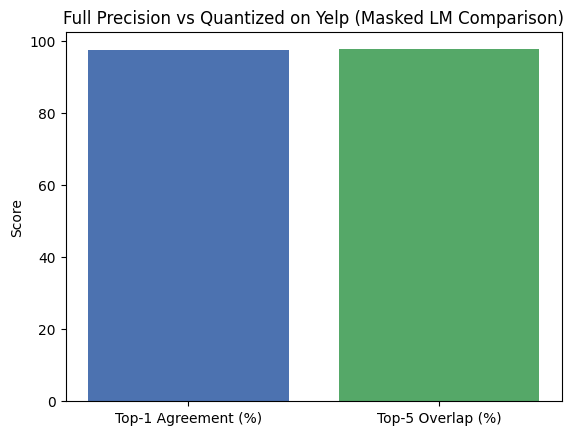

In [14]:
metrics = {
    "Top-1 Agreement (%)": np.mean(top1)*100,
    "Top-5 Overlap (%)": np.mean(top5)*100,
}

plt.bar(metrics.keys(), metrics.values(), color=["#4c72b0", "#55a868"])
plt.ylabel("Score")
plt.title("Full Precision vs Quantized on Yelp (Masked LM Comparison)")
plt.show()
